# Rootzone model: build + rich features + walk-forward
Build master_data, engineer rich features, train RF on anchor intervals, and evaluate per-step.

In [6]:
# Repo paths (works even when notebook is in scripts/)
from pathlib import Path

def find_repo_root(start=None):
    start = Path.cwd() if start is None else Path(start)
    for p in [start, *start.parents]:
        if (p / 'data').exists():
            return p
    return start

ROOT = find_repo_root()
RAW = ROOT / 'data' / 'raw'
PROCESSED = ROOT / 'data' / 'processed'
PLOTS = ROOT / 'plots'
PLOTS.mkdir(exist_ok=True)


In [7]:
import pandas as pd
import numpy as np
from pathlib import Path
from collections import defaultdict
from datetime import datetime, timedelta, time
import csv
from typing import Any, Dict, List, Optional
from openpyxl import load_workbook
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt


In [8]:
from pathlib import Path
from typing import Optional

def find_repo_root(start: Optional[Path] = None) -> Path:
    p = (start or Path.cwd()).resolve()
    for parent in [p, *p.parents]:
        if (parent / 'data').exists():
            return parent
    return p

ROOT = find_repo_root()
RAW = ROOT / 'data' / 'raw'
PROCESSED = ROOT / 'data' / 'processed'
# OUTPUTS removed; use PROCESSED or PLOTS
print('ROOT:', ROOT)
print('RAW:', RAW)

def resolve_input(filename: str) -> Path:
    # prefer data/raw; fall back to repo root for backward compatibility
    p1 = RAW / filename
    p2 = PROCESSED / filename
    p3 = ROOT / filename
    if p1.exists():
        return p1
    if p2.exists():
        return p2
    if p3.exists():
        return p3
    raise FileNotFoundError(f'Cannot find {filename} in {RAW} or {ROOT}')


ROOT: C:\Users\edene\OneDrive\שולחן העבודה\Predictive_Modeling_Of_Rootzone_Variables_Using_Greenhouse_Data
RAW: C:\Users\edene\OneDrive\שולחן העבודה\Predictive_Modeling_Of_Rootzone_Variables_Using_Greenhouse_Data\data\raw


In [9]:
# Build master_data from raw files

def floor_to_10min(dt: datetime) -> datetime:
    minute = (dt.minute // 10) * 10
    return dt.replace(minute=minute, second=0, microsecond=0)

def parse_time_flex(text: str) -> time:
    text = text.strip()
    parts = text.split(":")
    if len(parts) >= 2:
        try:
            h = int(parts[0]); m = int(parts[1]); s = int(parts[2]) if len(parts) >= 3 and parts[2] else 0
            return time(hour=h, minute=m, second=s)
        except Exception:
            pass
    for fmt in ("%H:%M:%S", "%H:%M"):
        try:
            return datetime.strptime(text, fmt).time()
        except Exception:
            continue
    raise ValueError(f"Unrecognized time format: {text}")

def parse_ts_variant(text: str, day_first: bool) -> datetime:
    norm = text.replace("-", "/").replace(".", "/").strip()
    if " " not in norm:
        raise ValueError("No space between date and time")
    date_part, time_part = norm.split(" ", 1)
    t_val = parse_time_flex(time_part)
    parts = date_part.split("/")
    if len(parts) < 3:
        raise ValueError("Date part incomplete")
    a, b, y = parts[0], parts[1], parts[2]
    if len(y) == 2:
        y = "20" + y
    if day_first:
        day, month = int(a), int(b)
    else:
        month, day = int(a), int(b)
    return datetime(int(y), month, day, t_val.hour, t_val.minute, t_val.second)

def parse_micro_ts(value: Any, prev_ts: Optional[datetime]) -> datetime:
    if isinstance(value, datetime):
        ts = value
    else:
        text = str(value).strip()
        candidates = []
        for day_first in (True, False):
            try:
                candidates.append(parse_ts_variant(text, day_first))
            except Exception:
                continue
        if not candidates:
            raise ValueError(f"Unrecognized micro-climate timestamp: {value}")
        if prev_ts is not None:
            best = None; best_delta = None
            for dt in candidates:
                delta = dt - prev_ts
                if delta >= timedelta(minutes=-5) and (best_delta is None or delta < best_delta):
                    best = dt; best_delta = delta
            ts = best if best is not None else candidates[0]
        else:
            ts = candidates[0]
    return ts

def parse_time_robust(val: Any) -> time:
    if isinstance(val, datetime):
        return val.time()
    if isinstance(val, time):
        return val
    return parse_time_flex(str(val))

def parse_date_dayfirst(text: str) -> datetime.date:
    text = text.strip()
    norm = text.replace("-", "/").replace(".", "/")
    parts = norm.split("/")
    if len(parts) >= 3:
        d, m, y = parts[0], parts[1], parts[2]
        if len(y) == 2:
            y = "20" + y
        return datetime(int(y), int(m), int(d)).date()
    for fmt in ("%d/%m/%Y", "%d/%m/%y", "%Y-%m-%d"):
        try:
            return datetime.strptime(text, fmt).date()
        except Exception:
            continue
    raise ValueError(f"Unrecognized date format: {text}")

def read_micro(path: str) -> List[Dict[str, Any]]:
    wb = load_workbook(path, read_only=True, data_only=True)
    ws = wb["micro_climate_rh_t_et0"]
    rows = ws.iter_rows(values_only=True)
    next(rows)
    data = []
    prev_ts = None
    base_ts = None
    interval = timedelta(minutes=10)
    for row in rows:
        if not row or row[0] is None:
            continue
        raw_ts = parse_micro_ts(row[0], prev_ts)
        if base_ts is None:
            base_ts = raw_ts
            seq_ts = base_ts
        else:
            seq_ts = base_ts + interval * len(data)
        prev_ts = raw_ts
        data.append({
            "timestamp": seq_ts,
            "ET0": row[1],
            "internal_air_temp_c": row[2],
            "internal_rh_%": row[3],
            "internal_radiation": row[4],
        })
    return data

def read_irrigation(path: str):
    wb = load_workbook(path, read_only=True, data_only=True)
    ws = wb.active
    rows = ws.iter_rows(values_only=True)
    next(rows)
    events = []
    for row in rows:
        if not row or row[0] is None:
            continue
        date_val, time_val, irr_ml, fert_type = row[0], row[1], row[2], row[3]
        if isinstance(date_val, datetime):
            date_only = date_val.date()
        else:
            parsed = None
            for fmt in ("%Y-%m-%d", "%d/%m/%Y", "%m/%d/%Y", "%d.%m.%Y", "%m.%d.%Y"):
                try:
                    parsed = datetime.strptime(str(date_val), fmt).date(); break
                except Exception:
                    continue
            if parsed is None:
                parsed = parse_date_dayfirst(str(date_val))
            date_only = parsed
        t_val = parse_time_robust(time_val)
        dt = datetime.combine(date_only, t_val)
        bucket = floor_to_10min(dt)
        fert_code = 0
        if isinstance(fert_type, str):
            f = fert_type.strip().upper()
            if f == "A":
                fert_code = 1
            elif f == "B":
                fert_code = 2
        events.append({"bucket": bucket, "irr_ml": irr_ml or 0.0, "fert_code": fert_code})
    return events

def build_irrigation_series(events):
    fert_by_bucket = {}
    irr_by_bucket = defaultdict(float)
    for ev in events:
        irr_by_bucket[ev["bucket"]] += ev["irr_ml"]
        if ev["fert_code"]:
            fert_by_bucket[ev["bucket"]] = max(fert_by_bucket.get(ev["bucket"], 0), ev["fert_code"])
    return irr_by_bucket, fert_by_bucket

def parse_ph_ec_date(val: Any) -> Optional[datetime.date]:
    if isinstance(val, datetime):
        return val.date()
    if val is None:
        return None
    s = str(val).strip()
    if not s:
        return None
    for sep in (".", "/", "-"):
        if sep in s:
            parts = s.replace("-", sep).replace("/", sep).split(sep)
            if len(parts) >= 3:
                d_raw, m_raw, y_raw = parts[0], parts[1], parts[2]
                for day_first in (True, False):
                    day, month = (d_raw, m_raw) if day_first else (m_raw, d_raw)
                    year = y_raw
                    if len(year) == 2:
                        year = "20" + year
                    try:
                        return datetime(int(year), int(month), int(day)).date()
                    except Exception:
                        continue
    for fmt in ("%Y-%m-%d", "%Y/%m/%d", "%m.%d.%Y", "%d.%m.%Y", "%m-%d-%Y", "%d-%m-%Y"):
        try:
            return datetime.strptime(s, fmt).date()
        except Exception:
            continue
    return None

def read_ph_ec(path: str):
    wb = load_workbook(path, read_only=True, data_only=True)
    ws = wb.active
    rows = ws.iter_rows(values_only=True)
    next(rows)
    measurements = []
    for row in rows:
        if not row or row[1] is None:
            continue
        date_part = parse_ph_ec_date(row[1])
        time_part = row[4]
        if date_part is None or time_part is None:
            continue
        t_val = parse_time_robust(time_part)
        dt = datetime.combine(date_part, t_val)
        measurements.append({"timestamp": dt, "ph": row[2], "ec_ms": row[3]})
    return measurements

def map_ph_ec_to_micro(timestamps: List[datetime], measurements: List[Dict[str, Any]]):
    ph_list = [None] * len(timestamps)
    ec_list = [None] * len(timestamps)
    for m in measurements:
        best_idx = None; best_diff = None
        for idx, ts in enumerate(timestamps):
            diff = abs(ts - m["timestamp"])
            if diff <= timedelta(minutes=10) and (best_diff is None or diff < best_diff):
                best_idx = idx; best_diff = diff
        if best_idx is not None:
            ph_list[best_idx] = m["ph"]
            ec_list[best_idx] = m["ec_ms"]
    return ph_list, ec_list

def read_soil_temp(path: str):
    data = {}
    with open(path, newline="") as f:
        reader = csv.DictReader(f)
        for row in reader:
            ts = datetime.strptime(row["datetime"], "%Y-%m-%d %H:%M:%S")
            data[ts] = float(row["soil_temp_pred"]) if row["soil_temp_pred"] != "" else None
    return data

def read_canopy(path: str):
    wb = load_workbook(path, read_only=True, data_only=True)
    ws = wb.active
    rows = ws.iter_rows(values_only=True)
    next(rows)
    canopy = {}
    for row in rows:
        if len(row) < 7:
            continue
        date_val = row[4]
        canopy_val = row[6]
        if date_val is None:
            continue
        if not isinstance(date_val, datetime):
            try:
                date_val = datetime.strptime(str(date_val), "%Y-%m-%d")
            except Exception:
                continue
        canopy[date_val.date()] = canopy_val
    return canopy

def build_master():
    micro = read_micro(str(resolve_input("micro_climate_rh_t_et0.xlsx")))
    events = read_irrigation(str(resolve_input("Irrigation + ALL Elemental Fractions schedule for one plant (100N).xlsx")))
    irr_by_bucket, fert_by_bucket = build_irrigation_series(events)
    ph_ec = read_ph_ec(str(resolve_input("PH+EC Final.xlsx")))
    soil_temp = read_soil_temp(str(resolve_input("soil_temp_predictions_full_range.csv")))
    canopy = read_canopy(str(resolve_input("Daily Canopy Cover Values.xlsx")))

    timestamps = [row["timestamp"] for row in micro]
    ph_list, ec_list = map_ph_ec_to_micro(timestamps, ph_ec)

    fert_flags = []
    soil_list = []
    canopy_list = []
    irr_current = []

    for i, ts in enumerate(timestamps):
        irr_now = irr_by_bucket.get(ts, 0.0)
        irr_current.append(irr_now)
        fert_flags.append(fert_by_bucket.get(ts, 0))
        soil_list.append(soil_temp.get(ts))
        canopy_list.append(canopy.get(ts.date()))

    df_out = pd.DataFrame({
        "timestamp": timestamps,
        "ET0": [r["ET0"] for r in micro],
        "internal_air_temp_c": [r["internal_air_temp_c"] for r in micro],
        "internal_rh_%": [r["internal_rh_%"] for r in micro],
        "internal_radiation": [r["internal_radiation"] for r in micro],
        "irrigation_ml_current": irr_current,
        "fertilization_flag": fert_flags,
        "ph": ph_list,
        "ec_ms": ec_list,
        "soil_temp_pred": soil_list,
        "canopy_cover": canopy_list,
    })
    df_out = df_out.sort_values("timestamp").set_index("timestamp")
    out_path = PROCESSED / "master_data.csv"
    df_out.to_csv(out_path, index=True)
    print(f"Wrote {out_path} with {len(df_out)} rows")
    return df_out

print("Building master_data ...")
df = build_master()


Building master_data ...
Wrote C:\Users\edene\OneDrive\שולחן העבודה\Predictive_Modeling_Of_Rootzone_Variables_Using_Greenhouse_Data\data\processed\master_data.csv with 16682 rows


In [10]:
# Rich feature engineering on master (10-minute timeline)
pi = np.pi
hours = df.index.hour
days = df.index.dayofyear

feat_dict = {}
feat_dict['hour_sin'] = np.sin(2*pi*hours/24)
feat_dict['hour_cos'] = np.cos(2*pi*hours/24)
feat_dict['doy_sin'] = np.sin(2*pi*days/365)
feat_dict['doy_cos'] = np.cos(2*pi*days/365)
feat_dict['is_weekend'] = df.index.weekday.isin([5,6]).astype(int)

irr_amt = df['irrigation_ml_current'].fillna(0)
irr_flag = (irr_amt > 0).astype(int)
fert_flag = (df['fertilization_flag'].fillna(0) > 0).astype(int)
fert_a = (df['fertilization_flag'] == 1).astype(int)
fert_b = (df['fertilization_flag'] == 2).astype(int)
feat_dict['irrigation_flag'] = irr_flag
feat_dict['fertigation_flag'] = fert_flag
feat_dict['fert_a_flag'] = fert_a
feat_dict['fert_b_flag'] = fert_b

idx_series = pd.Series(df.index, index=df.index)
last_irr_time = pd.Series(df.index.where(irr_flag==1), index=df.index).ffill()
last_fert_time = pd.Series(df.index.where(fert_flag==1), index=df.index).ffill()
feat_dict['time_since_irrigation_minutes'] = (idx_series - last_irr_time).dt.total_seconds() / 60
feat_dict['time_since_fertigation_minutes'] = (idx_series - last_fert_time).dt.total_seconds() / 60

windows = {6:'1h', 18:'3h', 36:'6h', 144:'24h'}
for win,name in windows.items():
    feat_dict[f'irr_sum_{name}'] = irr_amt.rolling(win, min_periods=1).sum()
    feat_dict[f'irr_flag_count_{name}'] = irr_flag.rolling(win, min_periods=1).sum()
    feat_dict[f'irr_flag_density_{name}'] = feat_dict[f'irr_flag_count_{name}'] / win
    if win in (36,144):
        feat_dict[f'fert_count_{name}'] = fert_flag.rolling(win, min_periods=1).sum()
        feat_dict[f'fert_a_count_{name}'] = fert_a.rolling(win, min_periods=1).sum()
        feat_dict[f'fert_b_count_{name}'] = fert_b.rolling(win, min_periods=1).sum()
        feat_dict[f'fert_density_{name}'] = feat_dict[f'fert_count_{name}'] / win

climate_cols = ['internal_air_temp_c','internal_rh_%','internal_radiation','ET0']
for col in climate_cols:
    for win,name in windows.items():
        feat_dict[f'{col}_roll_mean_{name}'] = df[col].rolling(win, min_periods=1).mean()
        feat_dict[f'{col}_roll_std_{name}'] = df[col].rolling(win, min_periods=1).std()
        feat_dict[f'{col}_roll_min_{name}'] = df[col].rolling(win, min_periods=1).min()
        feat_dict[f'{col}_roll_max_{name}'] = df[col].rolling(win, min_periods=1).max()
    feat_dict[f'{col}_diff_10m'] = df[col].diff()
    feat_dict[f'{col}_diff_1h'] = df[col] - df[col].shift(6)
    feat_dict[f'{col}_slope_1h'] = (df[col] - df[col].shift(6)) / 6
    feat_dict[f'{col}_slope_3h'] = (df[col] - df[col].shift(18)) / 18

feat_dict['vpd_proxy'] = (1 - df['internal_rh_%']/100.0) * df['internal_air_temp_c']

if 'soil_temp_pred' in df.columns:
    for win,name in {36:'6h', 144:'24h'}.items():
        feat_dict[f'soil_temp_mean_{name}'] = df['soil_temp_pred'].rolling(win, min_periods=1).mean()
        feat_dict[f'soil_temp_std_{name}'] = df['soil_temp_pred'].rolling(win, min_periods=1).std()
        feat_dict[f'soil_temp_slope_{name}'] = (df['soil_temp_pred'] - df['soil_temp_pred'].shift(win)) / win


feat_dict['rad_x_temp'] = df['internal_radiation'] * df['internal_air_temp_c']
feat_dict['et0_x_temp'] = df['ET0'] * df['internal_air_temp_c']
feat_dict['rh_x_temp'] = df['internal_rh_%'] * df['internal_air_temp_c']
feat_dict['irr6h_x_radiation'] = feat_dict['irr_sum_6h'] * df['internal_radiation']

feat_df = pd.DataFrame(feat_dict, index=df.index)
# Save full master timeline with engineered features (no filtering on pH/EC)
master_with_features = df.join(pd.DataFrame(feat_dict, index=df.index))
master_features_path = PROCESSED / 'master_data_with_features.csv'
master_with_features.to_csv(master_features_path)
print('Saved', master_features_path, 'rows:', len(master_with_features), 'cols:', master_with_features.shape[1])
mask_all = feat_df.notna().all(axis=1)
feat_df = feat_df.loc[mask_all]
df_feat = df.loc[mask_all]
print('feature rows', len(feat_df))


Saved C:\Users\edene\OneDrive\שולחן העבודה\Predictive_Modeling_Of_Rootzone_Variables_Using_Greenhouse_Data\data\processed\master_data_with_features.csv rows: 16682 cols: 132
feature rows 16512


In [11]:
# Build ds with anchor intervals + interval-aggregated features (t0 -> t1)
#
# Real-life intent:
# - At time t0 (current pH/EC), you also have a climate forecast over (t0, t1]
#   and a planned irrigation/fert schedule over (t0, t1].
# - So we summarize the *interval inputs* between samples and learn to predict the next sample.

anchors = df[df['ph'].notna() & df['ec_ms'].notna()].copy()
anchors['t1'] = anchors.index.to_series().shift(-1)
anchors['ph1'] = anchors['ph'].shift(-1)
anchors['ec1'] = anchors['ec_ms'].shift(-1)
anchors['gap_hours'] = (anchors['t1'] - anchors.index.to_series()).dt.total_seconds() / 3600
anchors['dph'] = anchors['ph1'] - anchors['ph']
anchors['dec'] = anchors['ec1'] - anchors['ec_ms']
anchors = anchors.dropna(subset=['t1','ph1','ec1','dph','dec'])

def build_interval_features(master: pd.DataFrame, intervals: pd.DataFrame) -> pd.DataFrame:
    rows = []
    for t0, row in intervals.iterrows():
        t1 = row['t1']
        seg = master.loc[t0:t1]
        feats: Dict[str, Any] = {}

        # Current observed rootzone state
        feats['ph0'] = float(row['ph'])
        feats['ec0'] = float(row['ec_ms'])
        feats['gap_hours'] = float(row['gap_hours'])
        feats['interval_steps_10m'] = int(len(seg))

        # Planned/observed actions between samples (aggregate over the interval)
        if 'irrigation_ml_current' in seg.columns:
            irr = pd.to_numeric(seg['irrigation_ml_current'], errors='coerce').fillna(0.0)
            feats['irr_ml_sum_t0_t1'] = float(irr.sum())
            feats['irr_event_count_t0_t1'] = int((irr > 0).sum())
        if 'fertilization_flag' in seg.columns:
            fert = pd.to_numeric(seg['fertilization_flag'], errors='coerce').fillna(0)
            feats['fert_event_count_t0_t1'] = int((fert > 0).sum())
            feats['fert_a_count_t0_t1'] = int((fert == 1).sum())
            feats['fert_b_count_t0_t1'] = int((fert == 2).sum())

        # Climate aggregates over the interval (use your predicted climate columns here if available)
        climate_cols = ['internal_air_temp_c', 'internal_rh_%', 'internal_radiation', 'ET0']
        for col in climate_cols:
            if col not in seg.columns:
                continue
            s = pd.to_numeric(seg[col], errors='coerce')
            feats[f'{col}_mean_t0_t1'] = float(s.mean())
            feats[f'{col}_std_t0_t1'] = float(s.std(ddof=0))
            feats[f'{col}_min_t0_t1'] = float(s.min())
            feats[f'{col}_max_t0_t1'] = float(s.max())
            feats[f'{col}_sum_t0_t1'] = float(s.sum())
            if len(s) >= 1:
                feats[f'{col}_delta_t0_t1'] = float(s.iloc[-1] - s.iloc[0])

        # VPD proxy (example derived interval aggregate)
        if 'internal_rh_%' in seg.columns and 'internal_air_temp_c' in seg.columns:
            rh = pd.to_numeric(seg['internal_rh_%'], errors='coerce')
            t = pd.to_numeric(seg['internal_air_temp_c'], errors='coerce')
            vpd_proxy = (1 - rh / 100.0) * t
            feats['vpd_proxy_mean_t0_t1'] = float(vpd_proxy.mean())
            feats['vpd_proxy_max_t0_t1'] = float(vpd_proxy.max())

        # Optional context variables
        if 'soil_temp_pred' in seg.columns:
            st = pd.to_numeric(seg['soil_temp_pred'], errors='coerce')
            feats['soil_temp_mean_t0_t1'] = float(st.mean())
            feats['soil_temp_std_t0_t1'] = float(st.std(ddof=0))
            feats['soil_temp_min_t0_t1'] = float(st.min())
            feats['soil_temp_max_t0_t1'] = float(st.max())
        if 'canopy_cover' in seg.columns:
            cc = pd.to_numeric(seg['canopy_cover'], errors='coerce')
            feats['canopy_mean_t0_t1'] = float(cc.mean())
            feats['canopy_t0'] = float(cc.iloc[0]) if len(cc) else np.nan
            feats['canopy_t1'] = float(cc.iloc[-1]) if len(cc) else np.nan

        rows.append(feats)

    return pd.DataFrame(rows, index=intervals.index)

interval_feats = build_interval_features(df, anchors)
ds = pd.concat([anchors[['t1', 'dph', 'dec']], interval_feats], axis=1)

# Drop any rows with NaNs in features (RF cannot handle NaNs)
feature_cols_tmp = [c for c in ds.columns if c not in ['t1', 'dph', 'dec']]
ds = ds.dropna(subset=feature_cols_tmp)
print('Built ds with intervals:', len(ds), '| features:', len(feature_cols_tmp))

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)
display(ds.head())


Built ds with intervals: 108


,t1,gap_hours,dph,dec,ph0,ec0,soil_temp_pred,internal_air_temp_c,internal_rh_%,internal_radiation,ET0,canopy_cover,hour_sin,hour_cos,doy_sin,doy_cos,is_weekend,irrigation_flag,fertigation_flag,fert_a_flag,fert_b_flag,time_since_irrigation_minutes,time_since_fertigation_minutes,irr_sum_1h,irr_flag_count_1h,irr_flag_density_1h,irr_sum_3h,irr_flag_count_3h,irr_flag_density_3h,irr_sum_6h,irr_flag_count_6h,irr_flag_density_6h,fert_count_6h,fert_a_count_6h,fert_b_count_6h,fert_density_6h,irr_sum_24h,irr_flag_count_24h,irr_flag_density_24h,fert_count_24h,fert_a_count_24h,fert_b_count_24h,fert_density_24h,internal_air_temp_c_roll_mean_1h,internal_air_temp_c_roll_std_1h,internal_air_temp_c_roll_min_1h,internal_air_temp_c_roll_max_1h,internal_air_temp_c_roll_mean_3h,internal_air_temp_c_roll_std_3h,internal_air_temp_c_roll_min_3h,internal_air_temp_c_roll_max_3h,internal_air_temp_c_roll_mean_6h,internal_air_temp_c_roll_std_6h,internal_air_temp_c_roll_min_6h,internal_air_temp_c_roll_max_6h,internal_air_temp_c_roll_mean_24h,internal_air_temp_c_roll_std_24h,internal_air_temp_c_roll_min_24h,internal_air_temp_c_roll_max_24h,internal_air_temp_c_diff_10m,internal_air_temp_c_diff_1h,internal_air_temp_c_slope_1h,internal_air_temp_c_slope_3h,internal_rh_%_roll_mean_1h,internal_rh_%_roll_std_1h,internal_rh_%_roll_min_1h,internal_rh_%_roll_max_1h,internal_rh_%_roll_mean_3h,internal_rh_%_roll_std_3h,internal_rh_%_roll_min_3h,internal_rh_%_roll_max_3h,internal_rh_%_roll_mean_6h,internal_rh_%_roll_std_6h,internal_rh_%_roll_min_6h,internal_rh_%_roll_max_6h,internal_rh_%_roll_mean_24h,internal_rh_%_roll_std_24h,internal_rh_%_roll_min_24h,internal_rh_%_roll_max_24h,internal_rh_%_diff_10m,internal_rh_%_diff_1h,internal_rh_%_slope_1h,internal_rh_%_slope_3h,internal_radiation_roll_mean_1h,internal_radiation_roll_std_1h,internal_radiation_roll_min_1h,internal_radiation_roll_max_1h,internal_radiation_roll_mean_3h,internal_radiation_roll_std_3h,internal_radiation_roll_min_3h,internal_radiation_roll_max_3h,internal_radiation_roll_mean_6h,internal_radiation_roll_std_6h,internal_radiation_roll_min_6h,internal_radiation_roll_max_6h,internal_radiation_roll_mean_24h,internal_radiation_roll_std_24h,internal_radiation_roll_min_24h,internal_radiation_roll_max_24h,internal_radiation_diff_10m,internal_radiation_diff_1h,internal_radiation_slope_1h,internal_radiation_slope_3h,ET0_roll_mean_1h,ET0_roll_std_1h,ET0_roll_min_1h,ET0_roll_max_1h,ET0_roll_mean_3h,ET0_roll_std_3h,ET0_roll_min_3h,ET0_roll_max_3h,ET0_roll_mean_6h,ET0_roll_std_6h,ET0_roll_min_6h,ET0_roll_max_6h,ET0_roll_mean_24h,ET0_roll_std_24h,ET0_roll_min_24h,ET0_roll_max_24h,ET0_diff_10m,ET0_diff_1h,ET0_slope_1h,ET0_slope_3h,vpd_proxy,soil_temp_mean_6h,soil_temp_std_6h,soil_temp_slope_6h,soil_temp_mean_24h,soil_temp_std_24h,soil_temp_slope_24h,rad_x_temp,et0_x_temp,rh_x_temp,irr6h_x_radiation
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2025-06-12 11:50:00,2025-06-29 12:10:00,408.333333,1.49,0.000,6.71,0.290,33.978159,33.131670,59.58328,634.63250,0.614856,0.085923,2.588190e-01,-0.965926,0.329408,-0.944188,0,0,0,0,0,110.0,2570.0,0.0,0.0,0.000000,133.333333,1.0,0.055556,266.666667,2.0,0.055556,0.0,0.0,0.0,0.000000,533.333333,4.0,0.027778,0.0,0.0,0.0,0.000000,33.145750,0.060756,33.057644,33.244003,32.150967,0.884860,30.783577,33.244003,30.131542,2.518999,24.478120,33.244003,27.762704,4.188579,21.436491,33.463634,-0.009977,0.534376,0.089063,0.168066,61.432167,1.249079,59.583280,63.344994,61.856522,1.918796,58.707886,65.60702,66.741727,6.326251,58.707886,77.86279,72.894094,9.827194,58.630530,87.37683,-2.531550,-4.413073,-0.735512,-0.138370,632.382615,26.701967,580.56335,656.3337,492.961989,109.994062,365.34015,656.3337,372.888226,175.618535,56.608624,656.3337,212.665231,248.608674,0.0,716.50250,-21.70120,82.57970,13.763283,7.703258,0.574122,0.065292,0.460040,0.623662,0.414909,0.133392,0.265499,0.623662,0.314586,0.161133,0.

## Targets
This notebook predicts only pH/EC deltas (`dph`, `dec`). `soil_temp_pred` is used only as an input feature (context), not as a target.

In [12]:
# Walk-forward on ds using RF (raw deltas) + top-25 feature selection per target
feature_cols = [c for c in ds.columns if c not in ['t1','dph','dec']]
X_all = ds[feature_cols]
y_all = ds[['dph','dec']]

TOP_K = 25
rf_params = dict(
    n_estimators=700,
    max_depth=9,
    min_samples_leaf=3,
    min_samples_split=10,
    random_state=42,
    n_jobs=-1,
)

def rf_top_features(X: pd.DataFrame, y: pd.Series, k: int = TOP_K) -> pd.Index:
    rf = RandomForestRegressor(**rf_params)
    rf.fit(X, y)
    imp = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
    return imp.head(min(k, len(imp))).index

initial_train = min(30, max(5, len(ds)//5))
if len(ds) <= initial_train + 1:
    raise RuntimeError(f"Not enough intervals: n={len(ds)} for initial_train={initial_train}")

# Select a fixed feature set using the initial training window (avoids look-ahead leakage)
ph_top = rf_top_features(X_all.iloc[:initial_train], y_all['dph'].iloc[:initial_train], k=TOP_K)
ec_top = rf_top_features(X_all.iloc[:initial_train], y_all['dec'].iloc[:initial_train], k=TOP_K)
selected_features = sorted(set(ph_top) | set(ec_top))
print(f"Selected {len(selected_features)} features (= union of top {TOP_K} for pH and EC).")
print('Top pH (dph) features:', list(ph_top))
print('Top EC (dec) features:', list(ec_top))

pred_rows = []
for i in range(initial_train, len(ds)):
    X_train = X_all.iloc[:i][selected_features]
    y_train = y_all.iloc[:i]
    X_test  = X_all.iloc[i:i+1][selected_features]
    y_test  = y_all.iloc[i:i+1]

    base_rf = RandomForestRegressor(**rf_params)
    model = MultiOutputRegressor(base_rf)
    model.fit(X_train, y_train)

    pred = model.predict(X_test)
    dph_pred, dec_pred = float(pred[0,0]), float(pred[0,1])
    ph0 = float(ds.iloc[i]['ph0']); ec0 = float(ds.iloc[i]['ec0'])
    dph_true = float(y_test['dph'].iloc[0]); dec_true = float(y_test['dec'].iloc[0])
    ph1_true = ph0 + dph_true; ec1_true = ec0 + dec_true
    ph1_pred = ph0 + dph_pred; ec1_pred = ec0 + dec_pred

    pred_rows.append({
        't0': ds.index[i], 't1': ds.iloc[i]['t1'], 'gap_hours': float(ds.iloc[i]['gap_hours']),
        'ph0': ph0, 'ec0': ec0,
        'ph1_true': ph1_true, 'ec1_true': ec1_true,
        'ph1_pred': ph1_pred, 'ec1_pred': ec1_pred,
        'dph_true': dph_true, 'dec_true': dec_true,
        'dph_pred': dph_pred, 'dec_pred': dec_pred,
        'train_intervals': i
    })

pred_df = pd.DataFrame(pred_rows).set_index('t0').sort_index()
print('Tested intervals:', len(pred_df), 'of', len(ds), '| first test idx:', initial_train)

ph1_true = pred_df['ph1_true'].values; ph1_pred = pred_df['ph1_pred'].values
ec1_true = pred_df['ec1_true'].values; ec1_pred = pred_df['ec1_pred'].values

def rmse(a,b):
    return float(np.sqrt(mean_squared_error(a,b)))
print("\n=== Overall next-observation performance ===")
print("PH MAE:", float(mean_absolute_error(ph1_true, ph1_pred)), "RMSE:", rmse(ph1_true, ph1_pred), "R2:", float(r2_score(ph1_true, ph1_pred)))
print("EC MAE:", float(mean_absolute_error(ec1_true, ec1_pred)), "RMSE:", rmse(ec1_true, ec1_pred), "R2:", float(r2_score(ec1_true, ec1_pred)))

pred_df['ph_abs_error'] = np.abs(pred_df['ph1_pred'] - pred_df['ph1_true'])
pred_df['ec_abs_error'] = np.abs(pred_df['ec1_pred'] - pred_df['ec1_true'])
pred_df['ph_signed_error'] = pred_df['ph1_pred'] - pred_df['ph1_true']
pred_df['ec_signed_error'] = pred_df['ec1_pred'] - pred_df['ec1_true']
print('\nPer-interval errors (all tested intervals):')
tbl = pred_df[['t1','gap_hours','ph_abs_error','ec_abs_error']].copy()
tbl = tbl.reset_index().rename(columns={'t0':'t0'})
tbl = tbl.rename(columns={tbl.columns[0]:'t0'})
tbl['gap_hours'] = tbl['gap_hours'].astype(float).round(3)
tbl['ph_abs_error'] = tbl['ph_abs_error'].astype(float).round(6)
tbl['ec_abs_error'] = tbl['ec_abs_error'].astype(float).round(6)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
display(tbl)


Tested intervals: 87 of 108 | first test idx: 21

=== Overall next-observation performance ===
PH MAE: 0.7353273488636197 RMSE: 0.9502533912098251 R2: 0.5217423021487828
EC MAE: 0.3438178432405363 RMSE: 0.5944777926338626 R2: 0.7742575323668169

Per-interval errors (all tested intervals):


,t0,t1,gap_hours,ph_abs_error,ec_abs_error
0,2025-08-06 10:00:00,2025-08-06 16:30:00,6.500,0.860235,1.093044
1,2025-08-06 16:30:00,2025-08-07 10:00:00,17.500,1.141286,0.734343
2,2025-08-07 10:00:00,2025-08-07 13:00:00,3.000,0.304817,0.018351
3,2025-08-07 13:00:00,2025-08-10 08:20:00,67.333,0.688809,0.030730
4,2025-08-10 08:20:00,2025-08-10 15:20:00,7.000,0.996968,1.540317
5,2025-08-10 15:20:00,2025-08-11 08:10:00,16.833,0.859439,0.352657
6,2025-08-11 08:10:00,2025-08-12 08:30:00,24.333,0.032444,1.771195
7,2025-08-12 08:30:00,2025-08-13 11:20:00,26.833,0.739371,0.188587
8,2025-08-13 11:20:00,2025-08-14 12:30:00,25.167,0.408154,0.125374
9,2025-08-14 12:30:00,2025-08-14 16:20:00,3.833,0.702322,0.322814


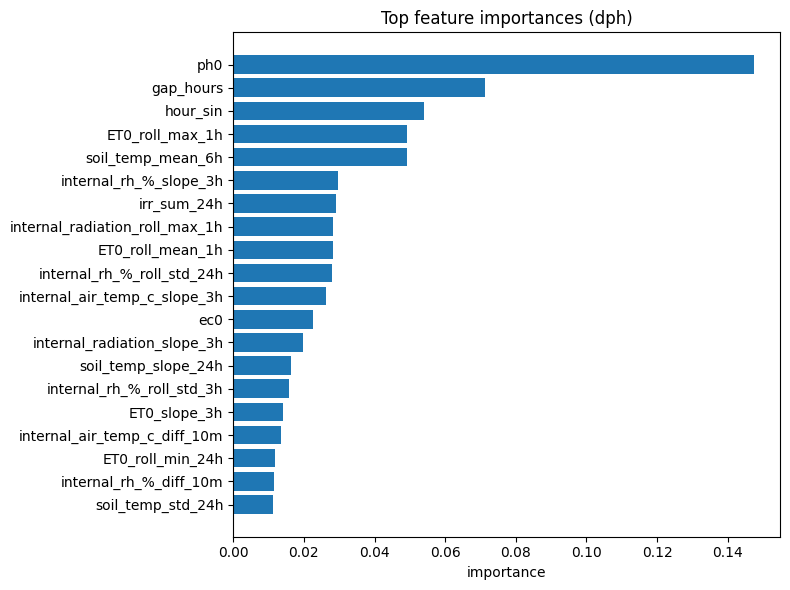

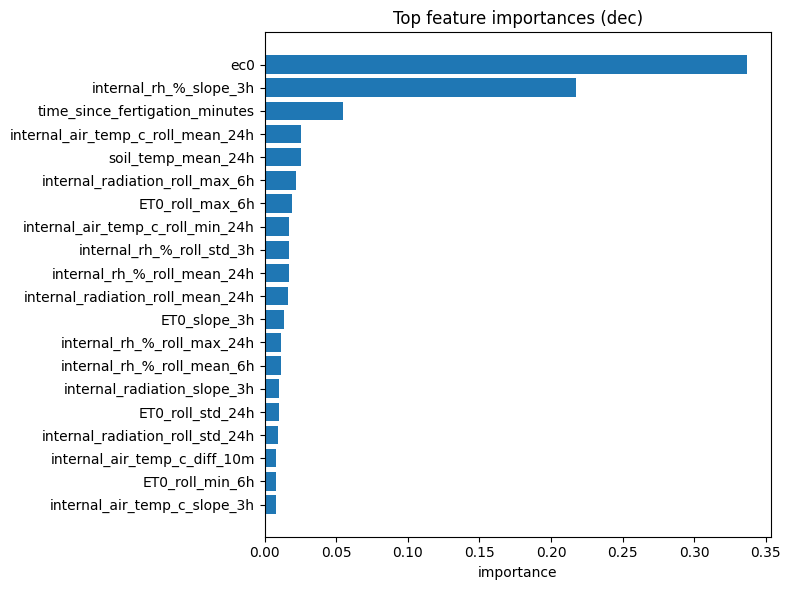

In [13]:
# Feature importance (display only) for the reduced-feature model
full_rf = RandomForestRegressor(**rf_params)
full_model = MultiOutputRegressor(full_rf)
full_model.fit(X_all[selected_features], y_all)

# Plot top features for each target using impurity-based importances
for tgt_name, est in zip(['dph','dec'], full_model.estimators_):
    imp = pd.Series(est.feature_importances_, index=selected_features).sort_values(ascending=False)
    top = imp.head(min(25, len(imp)))
    plt.figure(figsize=(8,6))
    plt.barh(top.index[::-1], top.values[::-1])
    plt.title(f'Top feature importances ({tgt_name})')
    plt.xlabel('importance')
    plt.tight_layout()
    plt.show()


c:\Users\edene\anaconda3\envs\tf-cpu\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


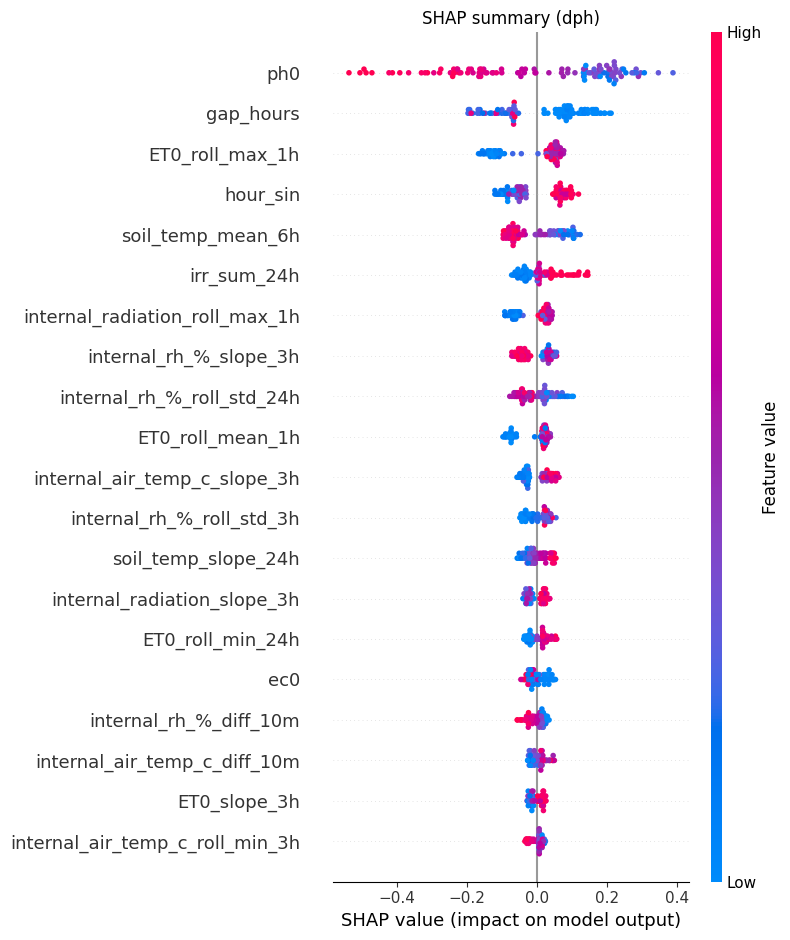

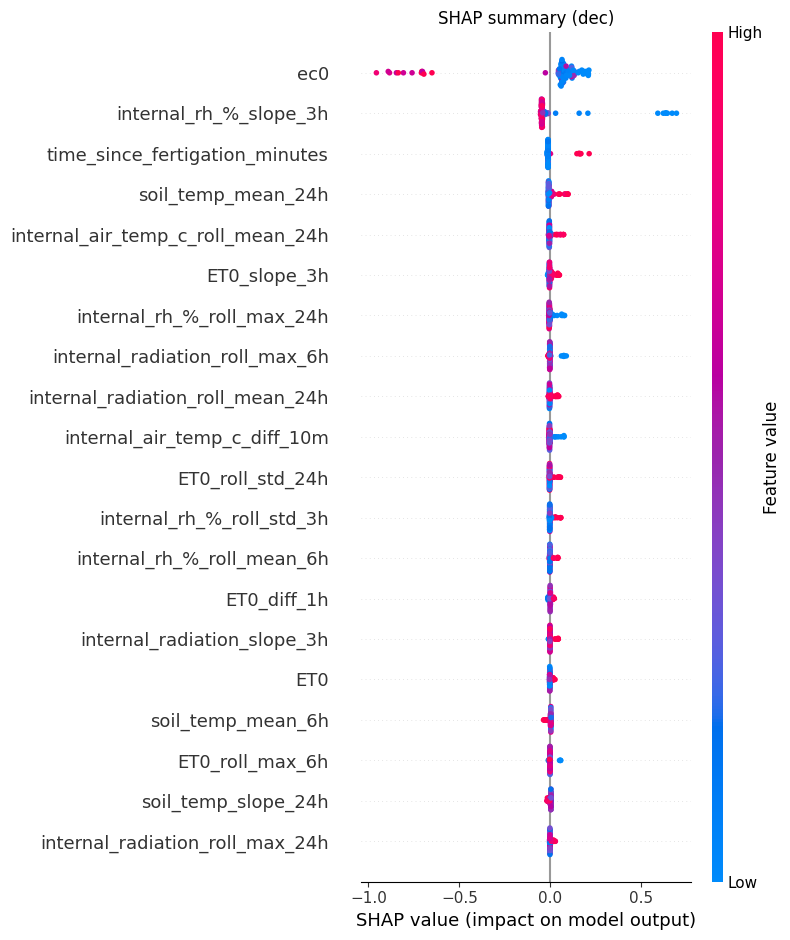

In [14]:
# SHAP summary plots (if shap is installed)
try:
    import shap
except ImportError as e:
    raise ImportError('shap is not installed in this environment. Install with: pip install shap') from e

# Train a final model once (same as used in feature importances)
final_rf = RandomForestRegressor(**rf_params)
final_model = MultiOutputRegressor(final_rf)
final_model.fit(X_all[selected_features], y_all)

# Use a sample to keep runtime reasonable
X_sample = X_all[selected_features].sample(n=min(300, len(X_all)), random_state=42)

for tgt_name, est in zip(['dph','dec'], final_model.estimators_):
    explainer = shap.TreeExplainer(est)
    shap_values = explainer.shap_values(X_sample)
    plt.figure()
    shap.summary_plot(shap_values, X_sample, show=False)
    plt.title(f'SHAP summary ({tgt_name})')
    plt.tight_layout()
    plt.show()


In [15]:
PROCESSED.mkdir(parents=True, exist_ok=True)
pred_df.to_csv(PROCESSED / 'rf_rootzone_model.csv')
print('Saved', PROCESSED / 'rf_rootzone_model.csv')
pred_df[['ph_abs_error','ec_abs_error','ph_signed_error','ec_signed_error']].to_csv(PROCESSED / 'per_interval_errors.csv')
print('Saved', PROCESSED / 'per_interval_errors.csv')


Saved C:\Users\edene\OneDrive\שולחן העבודה\Predictive_Modeling_Of_Rootzone_Variables_Using_Greenhouse_Data\data\processed\rf_rootzone_model.csv
Saved C:\Users\edene\OneDrive\שולחן העבודה\Predictive_Modeling_Of_Rootzone_Variables_Using_Greenhouse_Data\data\processed\per_interval_errors.csv
